[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AnyLoc/AnyLoc/blob/main/demo/images_vlad_clusters.ipynb)

# Image Clusters Demo

Given many images, get the VLAD cluster (patch descriptor assignment regions) and retrieve images with most similar regions.

## Setup



### Google Colab

- Run this section only if running this notebook on Google Colab.
- If you're running this section on your local machine, jump to `Downloading data` sub-section.

In [1]:
# Ensure that utilities.py module is there
import os
import requests
if os.path.isfile('utilities.py'):
    print('Found utilities.py')
else:
    print("Could not find utilities.py, downloading it")
    url = "https://raw.githubusercontent.com/AnyLoc/AnyLoc/main/demo/utilities.py"
    file_data = requests.get(url, allow_redirects=True)
    with open('utilities.py', 'wb') as handler:
        handler.write(file_data.content)

Found utilities.py


In [2]:
# Install other things
print("Trying to access utility libraries")
try:
    import einops
    import fast_pytorch_kmeans
    import distinctipy
    import onedrivedownloader
    print("Can access utility libraries")
except ImportError:
    print("Installing utility libraries")
    !pip install fast_pytorch_kmeans
    !pip install einops
    !pip install distinctipy
    !pip install onedrivedownloader

Trying to access utility libraries
Can access utility libraries


In [3]:
print("Verifying NVIDIA GPU is available")
!nvidia-smi -L
print("Please see that the GPU has at least 16 GB VRAM free")
!nvidia-smi

Verifying NVIDIA GPU is available
GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-e356fcd4-1d44-a564-e38c-d5c80c7a1b2e)
GPU 1: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-5d97153c-baaa-6e31-90f3-1dd2a2dda19d)
Please see that the GPU has at least 16 GB VRAM free
Wed Aug 16 21:21:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 36%   27C    P8    16W / 250W |      0MiB / 11264MiB |      0%      Defau

#### Downloading Data

Downloading

- `cache`: Vocabulary (cluster centers) and test images

In [4]:
# Download data from OneDrive
from onedrivedownloader import download
from utilities import od_down_links
# Link
ln = od_down_links["cache"]
# Download and unzip
if os.path.isdir("./cache"):
    print("Cache folder already exists!")
else:
    print("Downloading the cache folder")
    download(ln, filename="cache.zip", unzip=True, unzip_path="./")
    print("Cache folder downloaded")

Cache folder already exists!


### Imports

Packages and utilities

In [5]:
# Import everything
import numpy as np
import cv2 as cv
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as tvf
from torchvision.transforms import functional as T
from PIL import Image
import matplotlib.pyplot as plt
import distinctipy as dipy
from typing import Literal, List
import glob
import os
import shutil
from copy import deepcopy
# DINOv2 imports
from utilities import DinoV2ExtractFeatures
from utilities import VLAD



### Utilities

In [6]:
# Variables
device = "cuda"

# Realpath expansion
_ex = lambda x: os.path.realpath(os.path.expanduser(x))


## Input 1 - Setup Environment

User input. Currently, only `dinov2_vitg14` is supported.

- Take model parameters, extract features (could be from cache)
- Get VLAD cluster assignments (argmin cluster center) and display all images

In [7]:
# Folder where the cache for this app is stored
cache_dir: str = _ex("./cache")
# Dino_v2 properties (parameters)
desc_layer: int = 31
desc_facet: Literal["query", "key", "value", "token"] = "value"
num_c: int = 8
# Domain for use case (deployment environment)
domain: Literal["aerial", "indoor", "urban"] = "urban"
# Maximum image dimension
max_img_size: int = 1024

# Verity everything
assert os.path.isdir(cache_dir), "Cache directory not found"



In [8]:
imgs_dir = f"./cache/imgs/{domain}"
assert os.path.isdir(imgs_dir), \
        f"Images directory {imgs_dir} not found"
# Load all image names
img_fnames = glob.glob(f"{imgs_dir}/*.jpg") +\
                glob.glob(f"{imgs_dir}/*.png")


## Processing 1: Extract Features

- If no cache: Generate the DINO features (from the given layer) and save the cache
- If cache exists: Go to `Retrieve from cache`


In [9]:
# DINO extractor
if "extractor" in globals():
    print(f"Extractor already defined, skipping")
else:
    extractor = DinoV2ExtractFeatures("dinov2_vitg14", desc_layer,
        desc_facet, device=device)
# Base image transformations
base_tf = tvf.Compose([
    tvf.ToTensor(),
    tvf.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225])
])

Using cache found in /home2/avneesh.mishra/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [10]:
patch_descs = []
for img_fn in img_fnames:
    img_fn = _ex(img_fn)
    with torch.no_grad():
        # Read image
        pil_img = Image.open(img_fn).convert('RGB')
        img_pt = base_tf(pil_img).to(device)
        if max(img_pt.shape[-2:]) > max_img_size:
            print(f"Image {img_fn} is too big!", end=' ')
            c, h, w = img_pt.shape
            print(f"Resized from {(h, w) =}", end=' ')
            # Maintain aspect ratio
            if h == max(img_pt.shape[-2:]):
                w = int(w * max_img_size / h)
                h = max_img_size
            else:
                h = int(h * max_img_size / w)
                w = max_img_size
            print(f"To {(h, w) =}")
            img_pt = T.resize(img_pt, (h, w), 
                    interpolation=T.InterpolationMode.BICUBIC)
            pil_img = pil_img.resize((w, h))  # This is cached later!
        # Make image patchable
        c, h, w = img_pt.shape
        h_new, w_new = (h // 14) * 14, (w // 14) * 14
        img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
        
        # Extract descriptors
        ret = extractor(img_pt)
        patch_descs.append({"img": pil_img, "descs": ret.cpu()})

Save cache

In [11]:
# Directory where cache is stored
cache_sdir = _ex("./cache/imgs_extractor")
ext_specifier = f"dinov2_l{desc_layer}_{desc_facet}_c{num_c}/{domain}"
cache_sdir = os.path.join(cache_sdir, ext_specifier)

if os.path.isdir(cache_sdir):
    print(f"Cache directory {cache_sdir} exists, overwriting!")
    # shutil.rmtree(cache_sdir)
else:
    print(f"Creating {cache_sdir}...")
    os.makedirs(cache_sdir)

Cache directory /scratch/avneesh.mishra/vl-vpr/apps/images_vlad_clusters/cache/imgs_extractor/dinov2_l31_value_c8/urban exists, overwriting!


In [12]:
print(f"Saving all tensors to {cache_sdir}")
for ts, fn in zip(patch_descs, img_fnames):
    sfn = os.path.basename(fn)
    sfn = f"{sfn[:sfn.rfind('.')]}.pt"
    print(f"Created {sfn}")
    torch.save(ts, os.path.join(cache_sdir, sfn))

Saving all tensors to /scratch/avneesh.mishra/vl-vpr/apps/images_vlad_clusters/cache/imgs_extractor/dinov2_l31_value_c8/urban
Created st-lucia_qu-20.pt
Created pitts-30k_qu-240.pt
Created pitts-30k_db-294.pt
Created st-lucia_db-21.pt
Created oxford_qu-75.pt
Created oxford_db-75.pt


### Retrieve from cache

In [13]:
# Directory where cache is stored
cache_sdir = _ex("./cache/imgs_extractor")
ext_specifier = f"dinov2_l{desc_layer}_{desc_facet}_c{num_c}/{domain}"
cache_sdir = os.path.join(cache_sdir, ext_specifier)

assert os.path.isdir(cache_sdir), "No cache directtory"

In [14]:
img_patch_descs = []
pil_imgs = []
img_fnames = []
for f in glob.glob(f"{cache_sdir}/*.pt"):
    file_data = torch.load(f)
    img_patch_descs.append(file_data["descs"])
    pil_imgs.append(file_data["img"])
    print(f"Loaded {os.path.basename(f)}")
    img_fnames.append(os.path.basename(f)[:-3])


Loaded pitts-30k_db-294.pt
Loaded oxford_qu-75.pt
Loaded st-lucia_qu-20.pt
Loaded st-lucia_db-21.pt
Loaded pitts-30k_qu-240.pt
Loaded oxford_db-75.pt


## Processing 2: Create VLAD Assignment Clusters

Use the following:

- `img_fnames`: File names (for association)
- `img_patch_descs`: The descriptors (DINOv2 extracted features) for each image
- `pil_imgs`: Images as `PIL.Image` objects

And create the cluster assignments for each image/file. Read cluster centers from cache (to make VLAD object).

- `desc_assignments`: Descriptor assignments (list of tensors, `dtype=int64`)
- `da_imgs`: PIL Images of the clusters

In [15]:
ext_specifier = f"dinov2_vitg14/l{desc_layer}_{desc_facet}_c{num_c}"
c_centers_file = os.path.join(cache_dir, "vocabulary", ext_specifier,
                            domain, "c_centers.pt")
assert os.path.isfile(c_centers_file), "Cluster centers not cached!"
c_centers = torch.load(c_centers_file)
assert c_centers.shape[0] == num_c, "Wrong number of clusters!"
desc_dim = img_patch_descs[0].shape[-1]
assert c_centers.shape[1] == desc_dim, "Wrong cluster dimensionality!"

Load VLAD with cached cluster centers

In [16]:
# VLAD object (without cluster centers)
print("Loading VLAD (ignore 'cluster directory exists' warning)")
vlad = VLAD(num_c, desc_dim=desc_dim, 
            cache_dir=os.path.dirname(c_centers_file))
# Restore the cache manually
vlad.fit(None)
# Generate residuals
res_vects = [vlad.generate_res_vec(query_desc[0]) \
            for query_desc in img_patch_descs]  # [['n', n_c, d]]
print("Generated residual vectors")

Loading VLAD (ignore 'cluster directory exists' warning)
Using cached cluster centers
Generated residual vectors


Descriptor assignments

In [17]:
desc_assignments = []
for fn, img, res in zip(img_fnames, pil_imgs, res_vects):
    print(f"Processing {fn}")
    # Residual image ('res' shape is '[n_p, n_c, d]')
    h, w, c = np.array(img).shape
    h_p, w_p = (h // 14), (w // 14)
    h_new, w_new = h_p * 14, w_p * 14
    assert h_p * w_p == res.shape[0], "Residual shape is not correct"
    # Descriptor assignments
    da = res.abs().sum(dim=2).argmin(dim=1).reshape(h_p, w_p)
    da = F.interpolate(da[None, None, ...].to(float), 
            (h_new, w_new), mode='nearest')[0, 0].to(da.dtype)
    # print(f"\tShapes: residual: {res.shape}, assignment: {da.shape}")
    desc_assignments.append(da)

Processing pitts-30k_db-294
Processing oxford_qu-75
Processing st-lucia_qu-20
Processing st-lucia_db-21
Processing pitts-30k_qu-240
Processing oxford_db-75


Coloring (for visualization) of all images

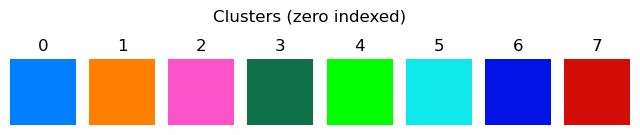

In [18]:
# Colors of each cluster
c_colors = dipy.get_colors(num_c, rng=928, # List of (R, G, B)
                        colorblind_type="Deuteranomaly")

fig = plt.figure(figsize=(num_c, 1.7))
gs = fig.add_gridspec(1, num_c)
for i, c in enumerate(c_colors):
    assert not (c[0] == c[1] == c[2] == 0), "Black not allowed, rerun"
    sq = np.ones((5, 5, 3)) * np.array(c)   # Colored square
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(sq)
    ax.set_title(f"{i}")
    ax.axis('off')
fig.suptitle("Clusters (zero indexed)")
plt.show(fig)


In [19]:
# Images showing descriptor assignments
da_imgs = []
np_colors = (np.array(c_colors) * 255).astype(np.uint8)
for fn, da in zip(img_fnames, desc_assignments):
    print(f"Processing {fn}")
    im = np.zeros((*da.shape, 3), dtype=np.uint8)
    for c in range(num_c):
        im[da == c] = np_colors[c]
    da_imgs.append(im)

Processing pitts-30k_db-294
Processing oxford_qu-75
Processing st-lucia_qu-20
Processing st-lucia_db-21
Processing pitts-30k_qu-240
Processing oxford_db-75


Show all images (with all clusters)

Processing oxford_db-75


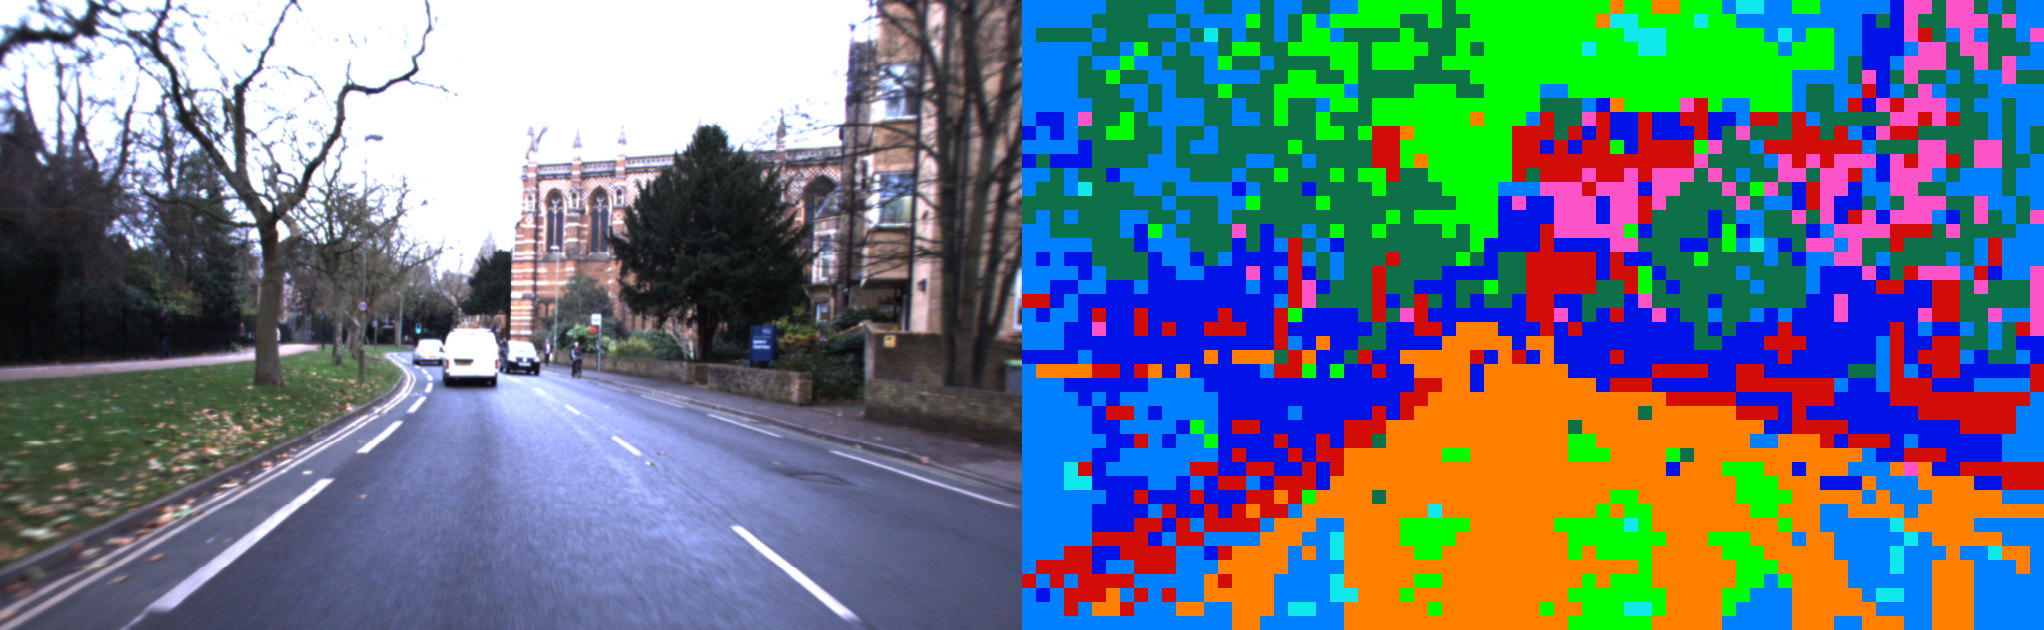

Processing oxford_qu-75


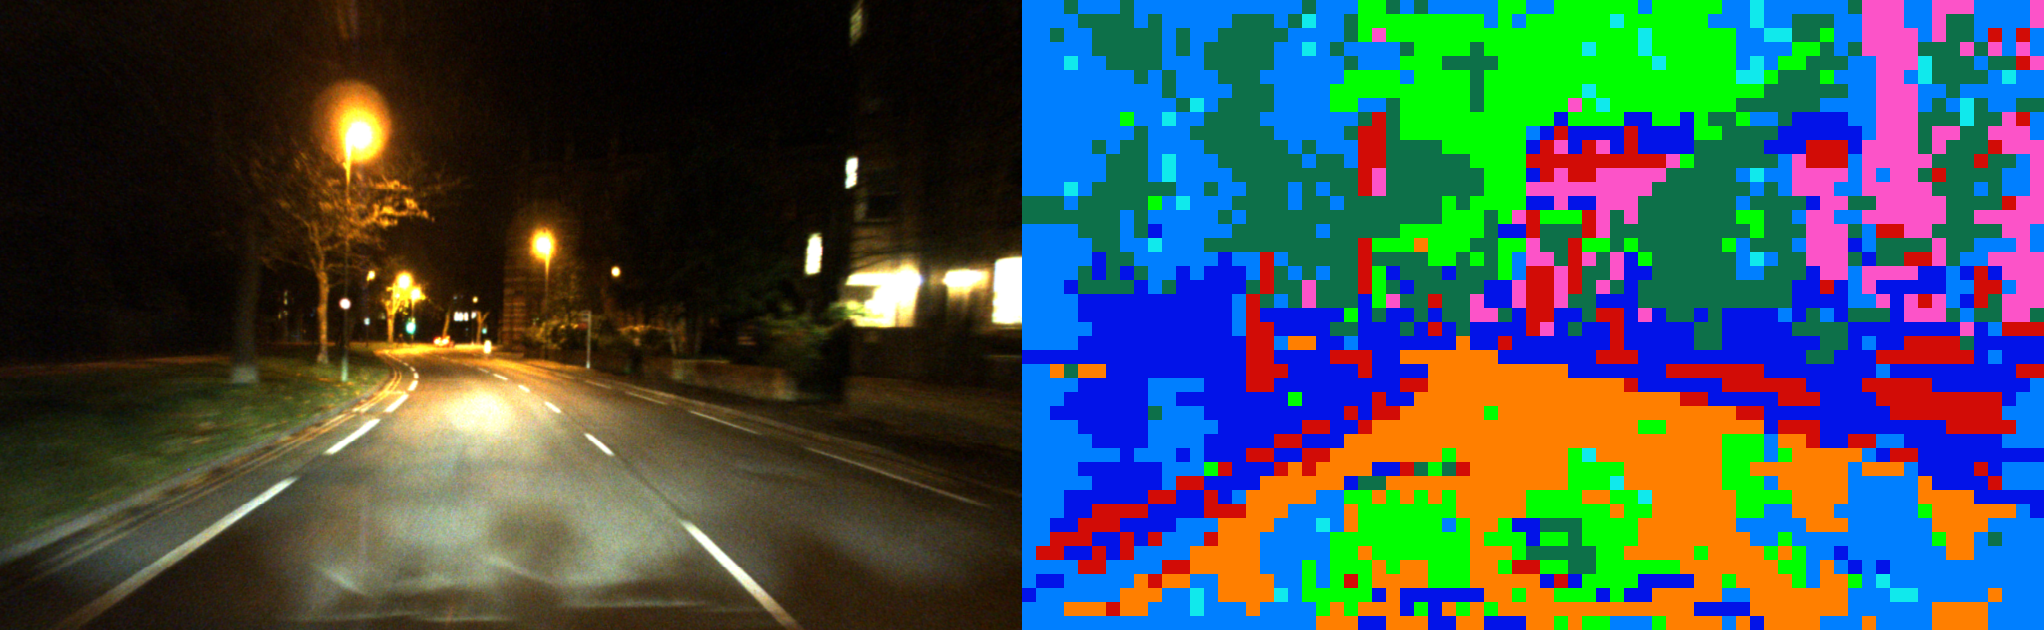

Processing pitts-30k_db-294


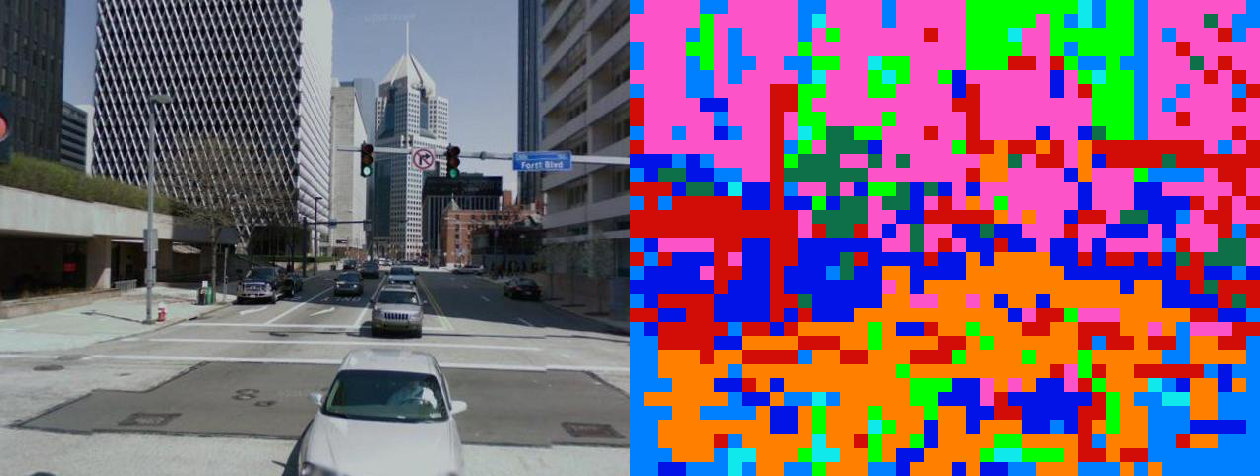

Processing pitts-30k_qu-240


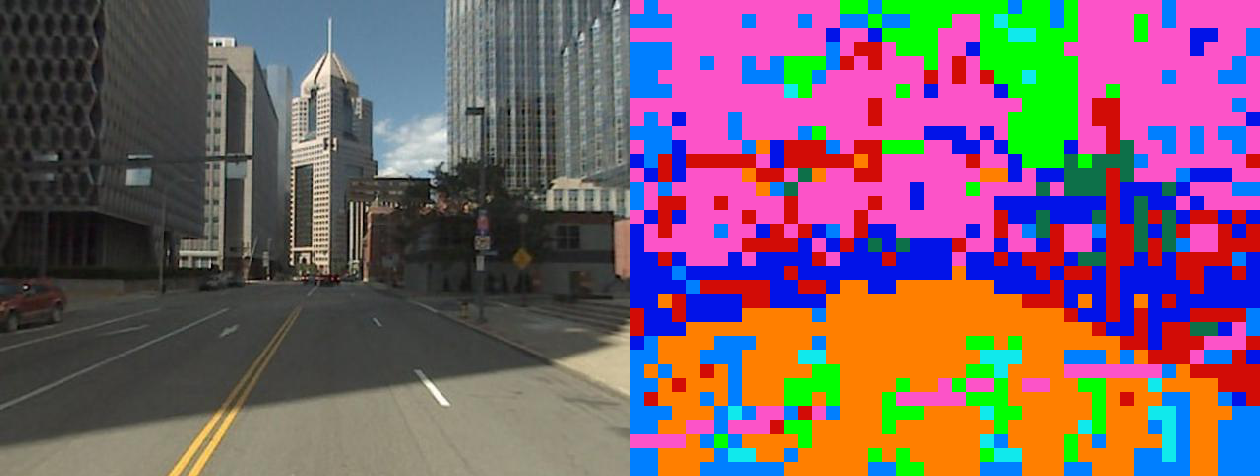

Processing st-lucia_db-21


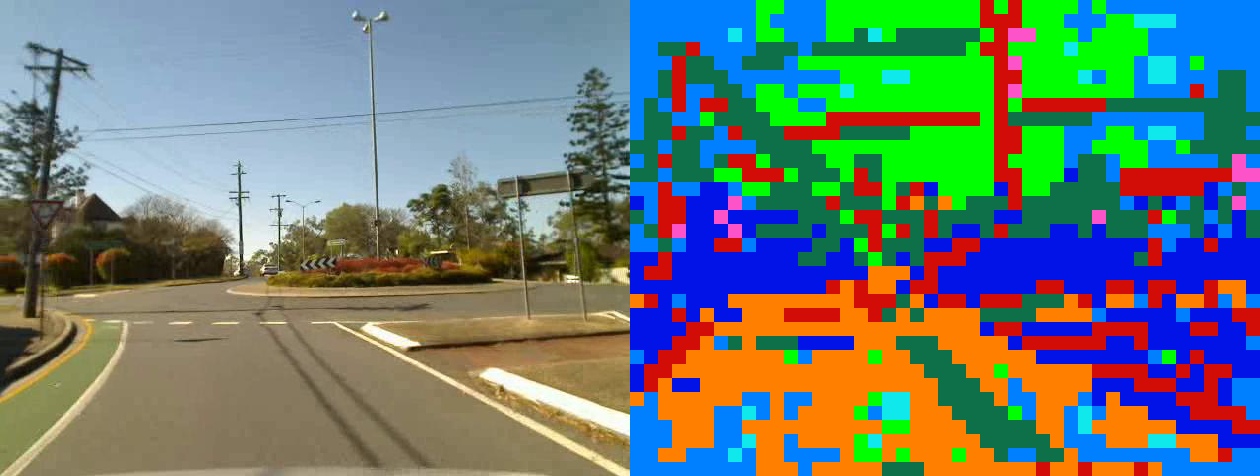

Processing st-lucia_qu-20


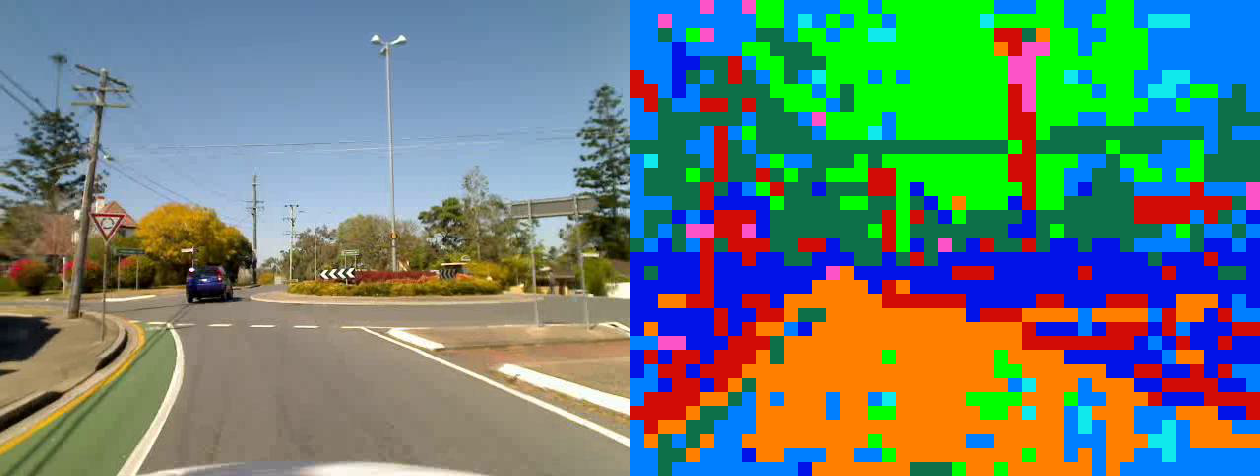

In [20]:
from IPython.display import display
np_imgs = []    # Numpy images (processed) for use in script
for img in pil_imgs:
    h, w, c = np.array(img).shape
    h_p, w_p = (h // 14), (w // 14)
    h_new, w_new = h_p * 14, w_p * 14
    img_np = F.interpolate(torch.tensor(np.array(img))\
            .permute(2, 0, 1)[None, ...], (h_new, w_new), 
            mode='nearest')[0].permute(1, 2, 0).numpy()
    np_imgs.append(img_np)
# Sort display items (by filename) to show database and query
_order = np.argsort(img_fnames)
_img_fnames = [img_fnames[k] for k in _order]
_pil_imgs = [pil_imgs[k] for k in _order]
_da_imgs = [da_imgs[k] for k in _order]
_np_imgs = [np_imgs[k] for k in _order]
for fn, img, da_img, np_img in zip(_img_fnames, _pil_imgs, _da_imgs, 
        _np_imgs):
    print(f"Processing {fn}")
    # Make tensor, permute, resize, permute back (c last), numpy
    display(Image.fromarray(np.concatenate((np_img, da_img), axis=1)))

## Input 2 - Select Clusters

Show images with selected clusters only.

- Select an image, and select cluster pixels on it. Here, just enter the coordinates by visualizing the image.
- Get list of clusters to filter out
- Show merged image with only those clusters

In [21]:
# Select an image (by name)
pick_img_name = "vpair_qu-122"
# Select pixel locations on the image (for selecting clusters)
pix_locs = [    # [X = W, Y = H]
    # [300, 350],
    # [388, 100],
    # [410, 280]
]
# Override the clusters (you can manually add some here)
if domain == "aerial":
    force_show_clusters = [1, 2, 4, 6]
elif domain == "indoor":
    force_show_clusters = [2, 4, 5, 6, 7]
elif domain == "urban":
    force_show_clusters = [1, 2, 3, 6, 7]
# Uncomment below for removing this override
# force_show_clusters = []
# Folder to store all results (filename will be used)
res_store_dir = f"./res/{domain}"

In [22]:
res_store_dir = _ex(res_store_dir)

if os.path.isdir(res_store_dir):
    print(f"Results directory {res_store_dir} already exists!")
    print("Possible overwriting could happen")
else:
    os.makedirs(res_store_dir)
    print(f"Created results directory: {res_store_dir}")


Results directory /scratch/avneesh.mishra/vl-vpr/apps/images_vlad_clusters/res/urban already exists!
Possible overwriting could happen


## Processing 3: Show specific clusters

Uses the following inputs

- `np_imgs`: Numpy images (`unit8`) of shape `H, W, 3` (patchifiable shape)
- `desc_assignments`: Torch (`dtype=torch.int64`) cluster assignments of shape `H, W`
- `da_imgs`: RGB Numpy images for cluster assignment (`unit8`) of shape `H, W, 3`. Only used for blending (final output)


Multiple or no matches found. Using 0!


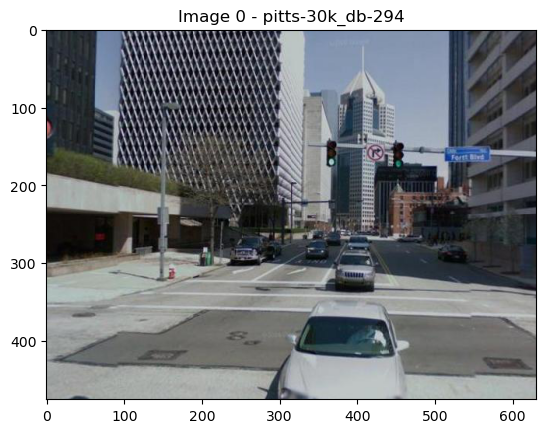

Showing clusters [1, 2, 3, 6, 7]


In [23]:
img_index = None if pick_img_name not in img_fnames else \
    [k for k, i in enumerate(img_fnames) if i == pick_img_name]

if type(img_index) == list and len(img_index) == 1:
    img_index = img_index[0]
else:
    print("Multiple or no matches found. Using 0!")
    img_index = 0

# Zero index clusters
show_clusters = deepcopy(force_show_clusters)

fig = plt.figure()
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.imshow(np_imgs[img_index])
ax.set_title(f"Image {img_index} - {img_fnames[img_index]}")
for i, px_loc in enumerate(pix_locs):
    try:
        ci = int(desc_assignments[img_index][px_loc[1]][px_loc[0]])
    except IndexError:
        print(f"Point {i}: {px_loc} is out of image")
        continue
    show_clusters.append(ci)
    ax.plot(px_loc[0], px_loc[1], 'rx')
plt.show(fig)
show_clusters = list(sorted(list(set(show_clusters))))
print(f"Showing clusters {show_clusters}")


Show the selected image with only this cluster

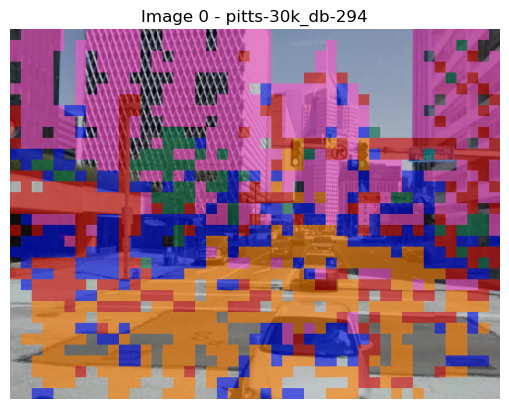

In [24]:
# Alpha (weight of RGB image); 1-alpha is for cluster mask
alpha = 0.4 # 60% image, 40% cluster assignment
# Create a mask for clusters
da_num = desc_assignments[img_index].numpy()
merge_mask = np.zeros_like(da_num).astype(np.float32)
for ci in show_clusters:
    merge_mask[da_num == ci] = 1
# Merged image
rgb_img = np_imgs[img_index]
da_img = da_imgs[img_index]
res_img = cv.addWeighted(rgb_img, alpha, da_img, 1-alpha, 0.0)
res_img[merge_mask == 0] = rgb_img[merge_mask == 0]
plt.title(f"Image {img_index} - {img_fnames[img_index]}")
plt.imshow(res_img)
plt.axis('off')
plt.show()

Show all images with the selected clusters

Saved mage: pitts-30k_db-294.png


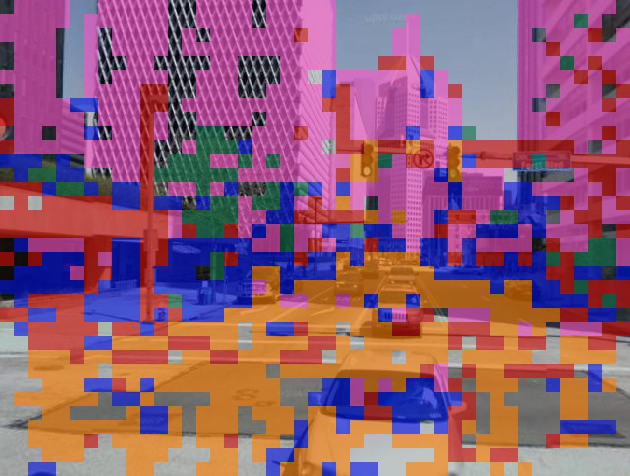

Saved mage: oxford_qu-75.png


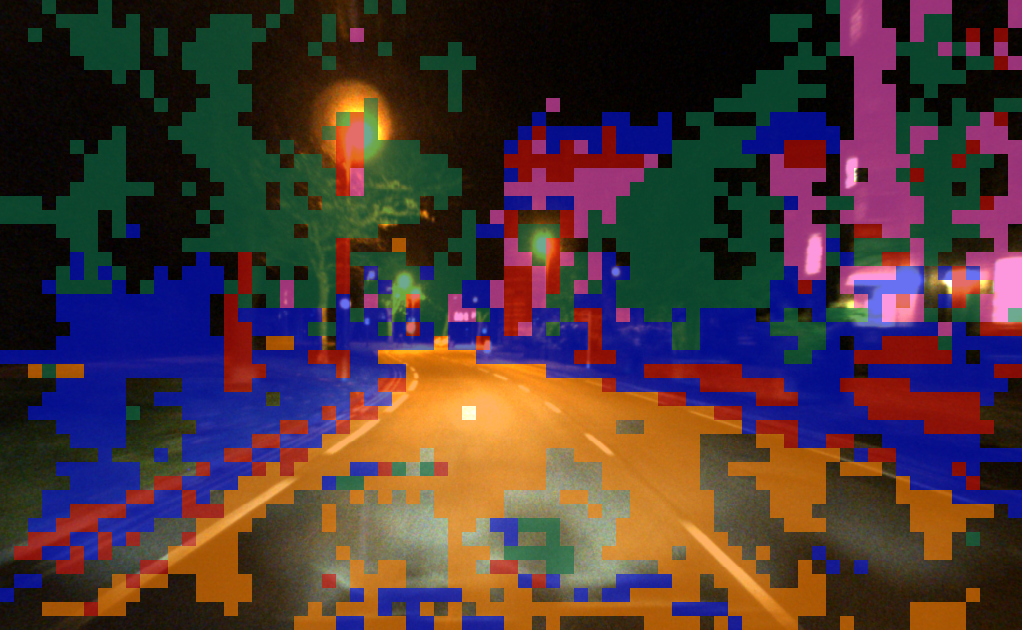

Saved mage: st-lucia_qu-20.png


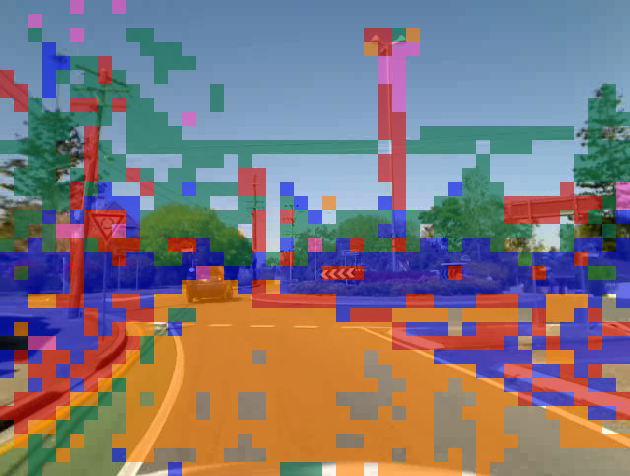

Saved mage: st-lucia_db-21.png


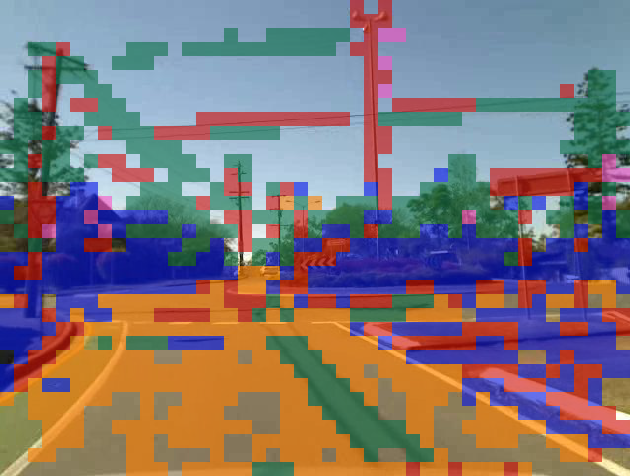

Saved mage: pitts-30k_qu-240.png


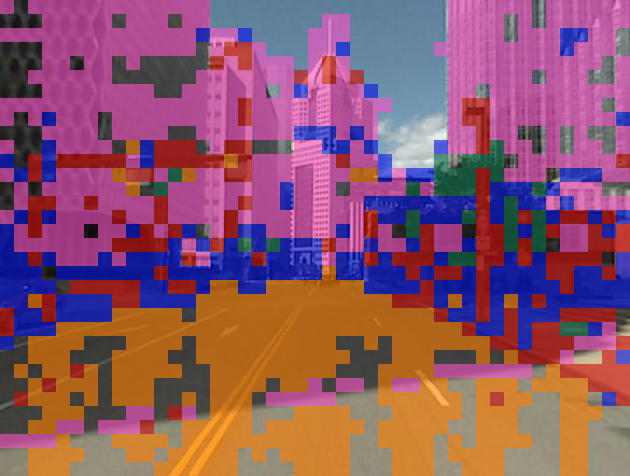

Saved mage: oxford_db-75.png


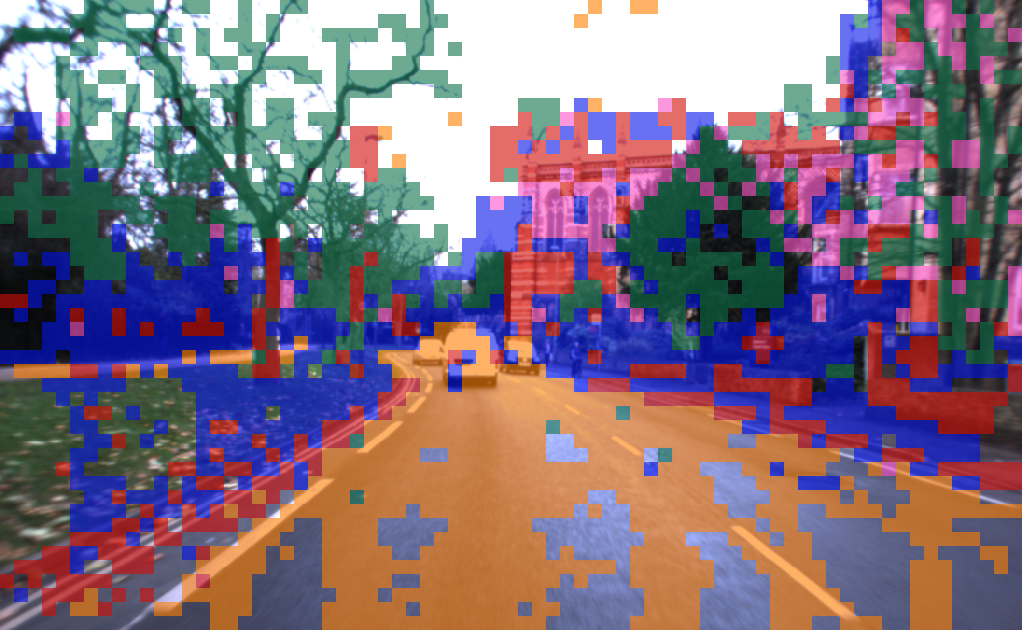

In [25]:
for i, (rgb_img, da_img) in enumerate(zip(np_imgs, da_imgs)):
    # Get mask
    da_clus_num = desc_assignments[i].numpy()
    merge_mask = np.zeros_like(da_clus_num).astype(np.float32)
    for ci in show_clusters:
        merge_mask[da_clus_num == ci] = 1
    # Merged image
    rgb_img, da_img = np_imgs[i], da_imgs[i]
    res_img = cv.addWeighted(rgb_img, alpha, da_img, 1-alpha, 0.0)
    res_img[merge_mask == 0] = rgb_img[merge_mask == 0]
    print(f"Saved mage: {img_fnames[i]}.png")
    pil_img = Image.fromarray(res_img)
    pil_img.save(f"{res_store_dir}/{img_fnames[i]}.png")
    display(pil_img)


## Input 3 - User given image

Do the clustering on a user-given image

- No caching done, only shows the results

In [30]:
# Image path
img_file = "./cache/imgs/st_lucia/40.jpg"
# Visualize the following clusters (zero-indexed)
show_clusters = [1, 2, 3, 6, 7]

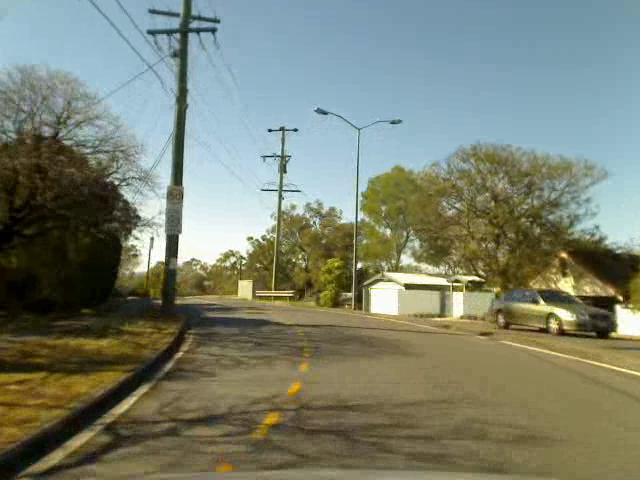

In [31]:
img_file = _ex(img_file)
assert os.path.isfile(img_file), "Image not found!"
display(Image.open(img_file))

## Procedure 4: Extract features and show VLAD clusters

- Ensure that only one `extractor` is defined (to prevent GPU OOM)
- Don't save any cache for the run


Extract DINOv2 VLAD residuals

In [32]:
# DINO extractor
if "extractor" in globals():
    print(f"Extractor already defined, skipping")
else:
    extractor = DinoV2ExtractFeatures("dinov2_vitg14", desc_layer,
        desc_facet, device=device)

# Patch descriptor
with torch.no_grad():
    # Read image
    pil_img = Image.open(img_file).convert('RGB')
    img_pt = base_tf(pil_img).to(device)
    if max(img_pt.shape[-2:]) > max_img_size:
        print("Image is too big!", end=' ')
        c, h, w = img_pt.shape
        print(f"Resized from {(h, w) =}", end=' ')
        # Maintain aspect ratio
        if h == max(img_pt.shape[-2:]):
            w = int(w * max_img_size / h)
            h = max_img_size
        else:
            h = int(h * max_img_size / w)
            w = max_img_size
        print(f"To {(h, w) =}")
        img_pt = T.resize(img_pt, (h, w), 
                interpolation=T.InterpolationMode.BICUBIC)
        pil_img = pil_img.resize((w, h))
    # Make image patchable
    c, h, w = img_pt.shape
    h_p, w_p = (h // 14), (w // 14)
    h_new, w_new = h_p * 14, w_p * 14
    img_pt = tvf.CenterCrop((h_new, w_new))(img_pt)[None, ...]
    img_np = F.interpolate(torch.tensor(np.array(pil_img))\
            .permute(2, 0, 1)[None, ...], (h_new, w_new),
            mode='nearest')[0].permute(1, 2, 0).numpy()
    # Extract descriptors
    patch_desc = extractor(img_pt)
patch_desc = patch_desc.cpu()
print(f"Patch descriptors: {patch_desc.shape = }")

# VLAD residuals
res_vect = vlad.generate_res_vec(patch_desc[0])
print(f"Generated residuals: {res_vect.shape = }")
# Cluster assignments
da = res_vect.abs().sum(dim=2).argmin(dim=1).reshape(h_p, w_p)
da = F.interpolate(da[None, None, ...].to(float), (h_new, w_new))\
        [0, 0].to(da.dtype)
print(f"Descriptor assignments shape: {da.shape = }")

Extractor already defined, skipping
Patch descriptors: patch_desc.shape = torch.Size([1, 1530, 1536])
Generated residuals: res_vect.shape = torch.Size([1530, 8, 1536])
Descriptor assignments shape: da.shape = torch.Size([476, 630])


Make the color image

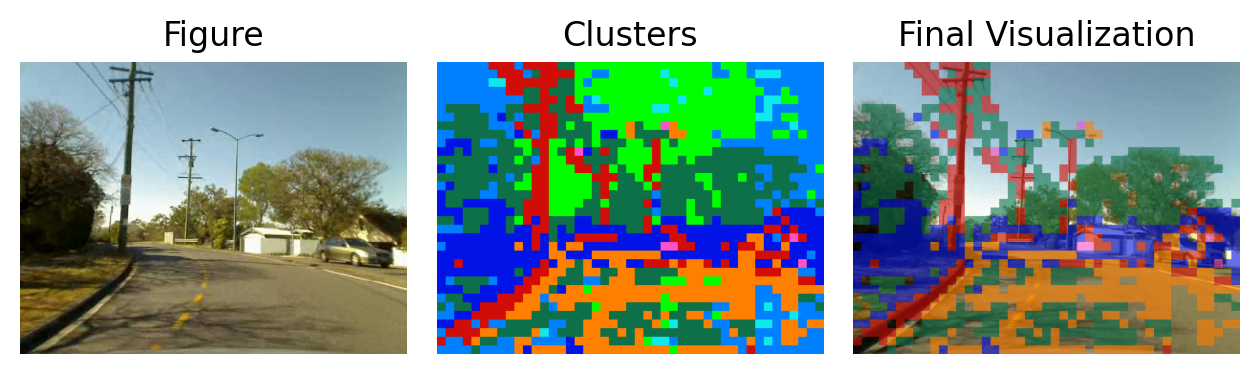

In [33]:
# Descriptor assignment clusters (all)
da_img = np.zeros((*da.shape, 3), dtype=np.uint8)
for c in range(num_c):
    da_img[da == c] = np_colors[c]
# Blend mask
if type(da) == torch.Tensor:
    da = da.numpy()
merge_mask = np.zeros_like(da).astype(np.float32)
for ci in show_clusters:
    merge_mask[da == ci] = 1
# Merged image
res_img = cv.addWeighted(img_np, alpha, da_img, (1-alpha), 0.0)
res_img[merge_mask == 0] = img_np[merge_mask == 0]
# Show all images
fig = plt.figure(dpi=200)
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set_title("Figure")
ax.imshow(img_np)
ax.axis('off')
ax = fig.add_subplot(gs[0, 1])
ax.set_title("Clusters")
ax.imshow(da_img)
ax.axis('off')
ax = fig.add_subplot(gs[0, 2])
ax.set_title("Final Visualization")
ax.imshow(res_img)
ax.axis('off')
fig.set_tight_layout(True)
plt.show(fig)